In [1]:
from datetime import datetime, timezone
import pytz

utc_dt = datetime.now(timezone.utc) # UTC time
dt = utc_dt.astimezone()
tz = pytz.timezone('Europe/Berlin')
berlin_now = datetime.now(tz)

print(f'{berlin_now:%Y-%m-%d %H:%M}')

2022-07-05 11:09


In [2]:
import pandas as pd
import numpy as np
import os

from matplotlib import pyplot as plt

In [3]:
eggnog = '/g/arendt/npapadop/data/spongfold_publish/eggnog/'
data = {}
for f in os.listdir(eggnog):
    name = '_'.join(f.split('_')[:2])
    data[name] = pd.read_csv(eggnog + f, sep='\t', skiprows=4, skipfooter=3, engine='python')

Protein count of Uniprot reference proteome. Used as input for emapper.

In [4]:
proteomes = {'A_queenslandica': 43437,
            'A_thaliana': 27473,
            'B_floridae': 28542,
            'C_elegans': 19818,
            'C_hemisphaerica': 19013,
            'C_intestinalis': 16680,
            'D_discoideum': 12727,
            'D_melanogaster': 13821,
            'D_rerio': 25707,
            'E_muelleri': 39329,
            'H_robusta': 23344,
            'H_sapiens': 20577,
            'L_gigantea': 23671,
            'M_musculus': 21985,
            'N_vectensis': 24428,
            'O_vulgaris': 18617,
            'R_varieornatus': 22940,
            'S_cerevisiae': 6059,
            'S_lacustris': 41945,
            'S_pistillata': 24067,
            'S_purpuratus': 26461,
            'T_adhaerens': 11518
            }

In [5]:
def annotation_quality(df):
    """
    Given an EggNOG output dataframe, it will count how many entries have a description and a name.
    """
    has_desc = np.sum(df['Description'] != '-')
    has_name = np.sum(df['Preferred_name'] != '-')
    return has_desc, has_name

In [6]:
for organism in proteomes.keys():
    n_genes = proteomes[organism]
    described, named = annotation_quality(data[organism])
    print(f'{organism}\t{described / n_genes * 100:.2f}%\t{named / n_genes * 100:.2f}%')

A_queenslandica	58.63%	25.47%
A_thaliana	85.36%	7.96%
B_floridae	76.50%	46.43%
C_elegans	70.58%	31.68%
C_hemisphaerica	45.81%	31.97%
C_intestinalis	66.64%	54.19%
D_discoideum	61.07%	2.92%
D_melanogaster	82.55%	52.80%
D_rerio	94.02%	76.98%
E_muelleri	40.01%	20.67%
H_robusta	58.45%	37.26%
H_sapiens	96.43%	94.91%
L_gigantea	50.85%	39.07%
M_musculus	96.39%	90.48%
N_vectensis	71.77%	39.38%
O_vulgaris	60.36%	46.51%
R_varieornatus	35.58%	28.60%
S_cerevisiae	90.82%	59.22%
S_lacustris	41.47%	30.21%
S_pistillata	56.87%	32.50%
S_purpuratus	79.90%	47.02%
T_adhaerens	80.45%	53.09%


In [7]:
res = np.zeros((len(proteomes), 4))
for i, organism in enumerate(proteomes.keys()):
    n_genes = proteomes[organism]
    described, named = annotation_quality(data[organism])
    described_not_named = described-named
    unannotated = n_genes-described
    res[i] = np.array([named/n_genes, described_not_named/n_genes, unannotated/n_genes, (described)/n_genes])

Let's add the information from CoFFE:

In [8]:
annot = pd.read_csv("../data/spongilla_lut.tsv", sep='\t')

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (6,7,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
annot = pd.read_csv("../data/spongilla_lut.tsv", sep='\t')
annot_nodoubl = annot.sort_values('bit score', ascending=False).drop_duplicates('protein_id')
keep = ['gene_id', 'Preferred_name_seq', 'Preferred_name_struct', 'Description_seq', 'Description_struct', 'Function [CC]', 'PFAMs_seq', 'PFAMs_struct']
annot_nodoubl = annot_nodoubl[keep]

In [10]:
seq_isnan = annot_nodoubl["Preferred_name_seq"].isnull()
seq_missing = annot_nodoubl["Preferred_name_seq"] == "-"
seq_no_desc = annot_nodoubl["Description_seq"].isnull()
seq_desc_mis = annot_nodoubl["Description_seq"] == "-"

struct_isnan = annot_nodoubl["Preferred_name_struct"].isnull()
struct_missing = annot_nodoubl["Preferred_name_struct"] == "-"
struct_no_desc = annot_nodoubl["Description_struct"].isnull()
struct_desc_mis = annot_nodoubl["Description_struct"] == "-"

seq_has_name = ~(seq_isnan | seq_missing)
seq_has_desc = ~(seq_no_desc | seq_desc_mis)
struct_has_name = ~(struct_isnan | struct_missing)
struct_has_desc = ~(struct_no_desc | struct_desc_mis)

In [11]:
coffe_named = struct_has_name & ~(seq_has_name | seq_has_desc)
coffe_described = struct_has_desc & ~(seq_has_name | seq_has_desc | coffe_named)

Formalise each category as a list so we can plot them successively:

In [16]:
labels = np.array(list(proteomes.keys()))
y_pos = np.arange(len(labels))
named = res[:, 0] * 100
described_not_named = res[:, 1] * 100
unannotated = res[:, 2] * 100
order = np.argsort(-res[:, 3])
sl_named = np.zeros(len(labels))
sl_named[18] = np.sum(coffe_named) / 41945 * 100
sl_desc_not_named = np.zeros(len(labels))
sl_desc_not_named[18] = np.sum(coffe_described) / 41945 * 100
unannotated[18] = unannotated[18] - sl_named[18] - sl_desc_not_named[18]

height = 0.35

In [13]:
from matplotlib import cm
palette = [cm.tab10.colors[0],
           cm.Set2.colors[5],
           cm.tab10.colors[-1],
           cm.tab10.colors[-2],
           'lightgray']

In [21]:
labels = np.array([l.replace('_', '. ') for l in labels])

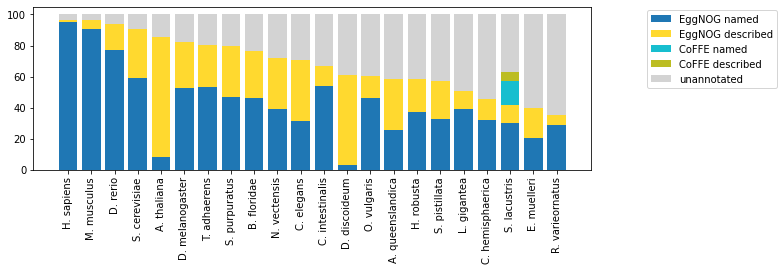

In [24]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(y_pos, named[order], label='EggNOG named', color=palette[0])
ax.bar(y_pos, described_not_named[order], bottom=named[order],
        label='EggNOG described', color=palette[1])
ax.bar(y_pos, sl_named[order], bottom=(named+described_not_named)[order],
        label='CoFFE named', color=palette[2])
ax.bar(y_pos, sl_desc_not_named[order], bottom=(named+described_not_named+sl_named)[order],
        label='CoFFE described', color=palette[3])
ax.bar(y_pos, unannotated[order], bottom=(named+described_not_named+sl_named+sl_desc_not_named)[order],
        label='unannotated', color=palette[4])
ax.legend(loc=(1.1, 0.5))
ax.set_xticks(y_pos)
ax.set_xticklabels(labels[order], rotation='vertical');
# ax.set_title('Percent functional annotation')
plt.savefig('./figures/analysis-eggnog_other_species.pdf')